In [1]:
import numpy as np
np.set_printoptions(precision=5)

from scipy.linalg import block_diag
from scipy.integrate import ode

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time
import warnings

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

	1 


1.0

## Neuron Types

In [2]:
class AdaptiveLIFT(LIFRate):
    
    '''
    Aaron Voelker
    https://github.com/nengo/nengo/issues/1423
    '''
    
    probeable = ('spikes', 'voltage', 'refractory_time', 'threshold')

    min_voltage = NumberParam('min_voltage', high=0)
    tau_adapt = NumberParam('tau_adapt', low=0)
    inc_adapt = NumberParam('inc_adapt', low=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0,
                 amplitude=1, tau_adapt=0.1, inc_adapt=0.05):
        super(AdaptiveLIFT, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage
        self.tau_adapt = tau_adapt
        self.inc_adapt = inc_adapt
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(gain)
        refractory_time = np.zeros_like(gain)
        threshold = np.ones_like(gain)

        return settled_firingrate(
            self.step_math, J, [voltage, refractory_time, threshold],
            dt=0.001, settle_time=0.3, sim_time=1.0)
    
    def gain_bias(self, max_rates, intercepts):
        return NeuronType.gain_bias(self, max_rates, intercepts)

    def max_rates_intercepts(self, gain, bias):
        return NeuronType.max_rates_intercepts(self, gain, bias)

    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = threshold and solve for t to compute the spike time
        # TODO: not sure if this mask is the right way to handle log domain errors
        threshold_spiked = threshold[spiked_mask]
        m = (voltage[spiked_mask] - threshold_spiked) / (J[spiked_mask] - threshold_spiked)
        t_spike = np.zeros_like(m)
        t_spike[m < 1] = dt + self.tau_rc * np.log1p(-m[m < 1])

        # update threshold using discretized lowpass filter
        # applied to the input 1 + spiked * inc_adapt 
        threshold -= ((1 + self.inc_adapt * spiked - threshold) *
                      np.expm1(-dt / self.tau_adapt))
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


@Builder.register(AdaptiveLIFT)
def build_alift(model, lif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.zeros(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
    model.sig[neurons]['threshold'] = Signal(
        np.ones(neurons.size_in), name="%s.threshold" % neurons)
    model.add_op(SimNeurons(
        neurons=lif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time'],
                model.sig[neurons]['threshold']]))

In [3]:
class WilsonRK4(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonRK4, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
        # TODO(arvoelke): Try replacing this solver with something like
        # http://www2.gsu.edu/~matrhc/PyDSTool.htm
        # The main consideration is that we need a callback to count spikes
        self.solver = ode(self._ode_fun).set_integrator(
            'dopri5', first_step=0.00005, nsteps=100,
            rtol=1e-2, atol=1e-3)  # runge-kutta method of order (4)5
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance],
            dt=0.001, settle_time=0.1, sim_time=1.0)

    def _ode_fun(self, dummy_t, y, J):  # first argument to scipy.integrate.ode
        V, R, H = np.split(y, 3)
        dV = (-(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) -
              26*R*(V + 0.95) - 13*H*(V + 0.95) + J)
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        return np.concatenate((
            dV / self.tau_V, dR / self.tau_R, dH / self.tau_H))

    def step_math(self, dt, J, spiked, V, R, H):
        # It's a little silly to be reinitializing the solver on
        # every time-step, but any other ways that I could think of would 
        # violate the nengo builder's assumption that the neuron's state is
        # encapsulated by the signals in SimNeurons
        self.solver.set_initial_value(np.concatenate((V, R, H)))
        self.solver.set_f_params(J.clip(max=self._maxJ))
        
        spiked[:] = 0
        AP = V > self.threshold
        def spike_detector(dummy_t, y):  # callback for each sub-step
            V_t = y[:len(V)] > self.threshold
            spiked[:] += V_t & (~AP)  # note the "+="
            AP[:] = V_t
        self.solver.set_solout(spike_detector)

        V[:], R[:], H[:] = np.split(self.solver.integrate(self.solver.t + dt), 3)
        if not self.solver.successful():
            raise ValueError("ODE solver failed with status code: %d" % (
                self.solver.get_return_code()))
        spiked[:] /= dt

        return spiked, V, R, H


@Builder.register(WilsonRK4)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['recovery'],
                model.sig[neurons]['conductance']]))

In [4]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA  # dopaminergic modulation ON/OFF
        self.max_rates = np.array([])
        self.intercepts = np.array([])

    def neuron_rates(self, wgain, wbias, x, n_neurons_test, stage, dt=0.001, tau=0.1, max_rate_pre=20):
        rate_pos = (max_rate_pre/2) * (x + 1)
        rate_neg = (max_rate_pre/2) * (-x + 1)
        spike_counts = np.zeros_like(n_neurons_test)
        neurons = []
        spk_vecs = []
        spk_recs = []
        stims = []
        syns = []
        ncs = []
        for n in range(n_neurons_test):
            neurons.append(neuron.h.Durstewitz())
            neurons[n].init()
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                if stage == 'gain':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias)))
                    ncs[-1].pre().interval = 1
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    w = wgain[n]
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, w))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                elif stage == 'bias':
                    # bias spikes
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70 if wbias[n] < 0 else 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, np.abs(wbias[n])))
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    ncs[-1].pre().interval = 1
                    # positive encoder presynaptic neuron
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = 0
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_pos
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
                    # negative encoder presynaptic neuron
                    if rate_neg <= 0: continue
                    stims.append(neuron.h.NetStim())
                    syns.append(neuron.h.ExpSyn(loc))
                    syns[-1].tau = tau * 1000
                    syns[-1].e = -70
                    ncs.append(neuron.h.NetCon(stims[-1], syns[-1], 0, 0, wgain))
                    ncs[-1].pre().interval = 1000.0 / rate_neg
                    ncs[-1].pre().start = 0
                    ncs[-1].pre().number = 1e10
                    ncs[-1].pre().noise = 0
        settle_time = 0.1
        sim_time = 1.0
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.dt = self.dt_neuron
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons_test):
            spk_vecs[n].play_remove()
        for nc in ncs:
            nc = None
        del(ncs)
        del(neurons)
        rates = np.array(spike_counts)/sim_time
        return rates
        
    def gain_bias(self, max_rates, intercepts,
            attempts=15, steps=10, y_thr=4, x_thr=1, delta_gain=3e-5, delta_bias=1e-5):
        print('finding gain/bias assuming on/off spiking inputs...')
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
#         print('max_rates', max_rates)
#         print('intercepts', intercepts)
        n_neurons = max_rates.shape[0]
        gain = np.zeros((n_neurons))
        bias = np.zeros((n_neurons))
        y_thr0 = y_thr
        for n in range(n_neurons):
            wgain_min = 0.0
            wgain_max = 1e-3
            wbias_min = -3e-6
            wbias_max = 3e-6
            gain_pass = False
            bias_pass = False
            min_x_int = 1e10
            max_delta = 0
            gain_best = 1e-10
            bias_best = 1e-10
            y_thr = y_thr0
#             print('target y-int', max_rates[n])
#             print('target x-int', intercepts[n])
            for a in range(attempts):
                if a == 0:
                    wbias = 0
                if a > 0 and a % 5 == 0:
                    y_thr += 1
                '''find wgain that achieve max_rates[n] at x=1 given previous wbias'''
                if not gain_pass:
                    wgain = np.linspace(wgain_min, wgain_max, steps)
                    y_rates = self.neuron_rates(wgain, wbias, x=1, n_neurons_test=steps, stage='gain')
#                     print('wgain', wgain)
#                     print('y_rates', y_rates)
                    wgain = wgain[np.argmin(np.abs(y_rates - max_rates[n]))]
                    y_int = y_rates[np.argmin(np.abs(y_rates - max_rates[n]))]
                else:
                    y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                '''find wbias that achieve 0<hz<1 at x=intercept[n] given previous wgain'''
                if not bias_pass:
                    wbias = np.linspace(wbias_min, wbias_max, steps)
                    x_rates = self.neuron_rates(wgain, wbias, x=intercepts[n], n_neurons_test=steps, stage='bias')
#                     print('wbias', wbias)
                    if (x_rates > x_thr).all() or (x_rates <= 0).all():
                        wbias = wbias[0]
                        x_int = x_rates[0]
                    else:
                        wbias = wbias[np.where(x_rates <= x_thr)[0][-1]]
                        x_int = x_rates[np.where(x_rates <= x_thr)[0][-1]]
                else:
                    x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
                a_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
                a_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
#                 print('attempt %s' %a)
#                 print('rate at y-int', a_y_int)
#                 print('rate at x-int', a_x_int)
                if 0 < a_x_int <= min_x_int:
                    min_x_int = a_x_int
                    if a_y_int-a_x_int > max_delta:
                        max_delta = a_y_int-a_x_int
                        gain_best = wgain
                        bias_best = wbias
                if a_x_int > a_y_int:  # oversaturated
                    wgain_max -= 3*delta_gain
                    wbias_min -= 3*delta_bias
                    wbias_max -= 3*delta_bias
                if np.abs(a_y_int - max_rates[n]) <= y_thr:
                    gain_pass = True
                elif a_y_int < max_rates[n] - y_thr:
                    wgain_min += delta_gain/2
                    wgain_max += delta_gain
                    gain_pass = False
                elif a_y_int > max_rates[n] + y_thr:
                    wgain_min -= delta_gain
                    wgain_max -= delta_gain/2
                    gain_pass = False
                if 0 < a_x_int <= x_thr:
                    bias_pass = True
                elif a_x_int > x_thr:
                    wbias_min -= delta_bias
                    wbias_max -= delta_bias/2
                    bias_pass = False
                elif a_x_int <= 0:
                    wbias_min += delta_bias/2
                    wbias_max += delta_bias
                    bias_pass = False
                if gain_pass and bias_pass:
                    print('optimized gain/bias for neuron %s' %n)
                    gain[n] = wgain
                    bias[n] = wbias
                    break
                if a == attempts-1:
                    print('did not find gain/bias for neuron %s that satisfies max_rates/intercepts' %n)
                    # use the highest rate / largest intercept found during optimization instead
                    gain[n] = gain_best
                    bias[n] = bias_best
            final_rate_y_int = self.neuron_rates([wgain], wbias, x=1, n_neurons_test=1, stage='gain')
            final_rate_x_int = self.neuron_rates(wgain, [wbias], x=intercepts[n], n_neurons_test=1, stage='bias')
        return gain, bias
        
    def max_rates_intercepts(self, gain, bias):
        """Measure firing rate at each eval_point using neuron_rates, estimate x_int and rate at y_int"""
        return self.max_rates, self.intercepts
    
    def step_math(self, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = voltage.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        if neuron.h.t < time*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        for n in range(n_neurons):
            if not np.isfinite(v_recs[n][-1]):
#                 warnings.warn('neuron %s returned nan voltage at t=%s' %(n, neuron.h.t*1000))
                voltage[n] = 0
            else:
                voltage[n] = v_recs[n][-1]
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        n_neurons=neurons.size_in,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = neuronop.neurons
    model.add_op(neuronop)
    
class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, n_neurons,  J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = [neuron.h.Durstewitz() for n in range(n_neurons)]
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(n_neurons)]
        for n in range(n_neurons):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn
    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

class TransmitSpikes(Operator):
    def __init__(self, neurons, taus, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.taus = taus
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        self.synapses = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                self.synapses[pre, post] = []
                for loc in [self.neurons[post].basal(0.5),
                            self.neurons[post].prox(0.5),
                            self.neurons[post].dist(0.5)]:
                    if len(self.taus) == 1:
                        syn = neuron.h.ExpSyn(loc)
                        syn.tau = self.taus[0]*1000
                    elif len(taus) == 2:
                        syn = neuron.h.Exp2Syn(loc)
                        syn.tau1 = np.min(self.taus)*1000
                        syn.tau2 = np.max(self.taus)*1000
                    syn.e = 0.0 if self.weights[pre, post] > 0 else -70.0
                    self.synapses[pre, post].append(syn)
#         self.netcons = np.zeros((1,1), dtype=list)
#         self.stim = neuron.h.NetStim()
#         self.syn = neuron.h.ExpSyn(self.neurons[0].soma(0.5))
#         self.syn.tau = 100
#         self.netcons[0,0] = [neuron.h.NetCon(None, self.syn, 0, 0, 1e-3)]
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = np.abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    nc.active(0)  # turn off until build finishes
                    self.netcons[pre, post].append(nc)
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
#             if int(t_neuron) % 10 == 0:
#                 for nc in self.netcons[0,0]:
#                     nc.event(t_neuron)
#                 for pre in range(spikes.shape[0]):
#                     for post in range(len(self.neurons)):
#                         for nc in self.netcons[pre, post]:
#                             nc.event(t_neuron)
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
#                 if int(t_neuron) % 10 == 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]
    
class BiasSpikes(Operator):
    def __init__(self, neurons, bias):
        super(BiasSpikes, self).__init__()
        self.neurons = neurons
        self.tau = 0.1
        self.bias = bias
        self.reads = []
        self.updates = []
        self.sets = []
        self.incs = []
        self.stims = []
        self.syns = []
        self.ncs = []
        for n in range(len(self.neurons)):
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                self.stims.append(neuron.h.NetStim())
                self.syns.append(neuron.h.ExpSyn(loc))
                self.syns[-1].tau = self.tau * 1000  # time constant of synapse on spiking bias input
                self.syns[-1].e = 0.0 if self.bias[n] > 0 else -70.0
                self.ncs.append(neuron.h.NetCon(self.stims[-1], self.syns[-1], 0, 0, np.abs(self.bias[n])))
                self.ncs[-1].pre().start = 0
                self.ncs[-1].pre().number = 1e10
                self.ncs[-1].pre().interval = 1
                self.ncs[-1].pre().noise = 0  # 0 for regular spikes at rate, 1 for poisson spikes at rate
                self.ncs[-1].active(0)  # turn off until build finishes
    def make_step(self, signals, dt, rng):
        def step():
            pass
        return step

@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):
        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"
        assert 0 < len(conn.synapse.den) <= 2, "only exponential and double exponential synapses supported"
        # optimize gain/bias with spiking inputs using attributes of conn.pre_obj and conn
        taus = -1.0/np.array(conn.synapse.poles)
        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        encoders = model.params[conn.post_obj].encoders
        bias = model.params[conn.post_obj].bias
        gain = np.array(model.params[conn.post_obj].gain.reshape((encoders.shape[0], 1)))
        # normalize by area under synapse curve, integral V(t) |b-a = F(b) - F(a), b=1s, a=0s
        if len(taus) == 1:
            gain /= taus[0] * (np.exp(-1.0/taus[0]) + 1)
        elif len(taus) == 2:
            gain /= (taus[1]/(taus[1]-taus[0])) * \
                ((taus[0]*np.exp(-1.0/taus[0]) + taus[1]*np.exp(-1.0/taus[1]))
                (taus[0]*1.0 + taus[1]*1.0))
        gain *= conn.k_weight
        # connect spiking poisson input to conn.post, if one doesn't already exist
        if not hasattr(conn, 'biasspike'):
            biasspike = BiasSpikes(model.params[conn.post_obj.neurons], bias)
            model.add_op(biasspike)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                conn.biasspike = biasspike
        # connect spikes from conn.pre to conn.post with computed weight matrix       
        scaled_enc = encoders * gain
        weights = np.dot(d.T, scaled_enc.T)
        transmitspike = TransmitSpikes(model.params[conn.post_obj.neurons], taus, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt)
        model.add_op(transmitspike)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            conn.transmitspike = transmitspike
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

def reset_neuron(sim):
    for key in list(sim.model.params.keys()):
        if type(key) == nengo.ensemble.Neurons:
#             sim.model.params.pop(key)
            del(sim.model.params[key])
    for op in sim.model.operators:
        if isinstance(op, SimNeuronNeurons):
            for v_rec in op.v_recs:
                v_rec.play_remove()
            for spk_vec in op.spk_vecs:
                spk_vec.play_remove()
            del(op.neurons)
        if isinstance(op, BiasSpikes):
            del(op.neurons)
            del(op.ncs)
        if isinstance(op, TransmitSpikes):
            del(op.neurons)
            del(op.netcons)


/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


## Plotting

In [5]:
def plot_filter(h, h_new, t=1, dt=0.001):
    times = np.arange(0, t, dt)
    y = h.impulse(len(times))
    y_new = h_new.impulse(len(times))
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(times, y, label="h")
    ax.plot(times, y_new, label="h_new")
    ax.set(xlabel='time (seconds)', ylabel='impulse response')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def bin_activities_values_1d(xhat_pre, act_bio, x_min=-1.5, x_max=1.5, n_neurons=10, n_eval_points=20):
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx
    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.zeros((n_neurons, n_eval_points))
    hz_stds = np.zeros((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x]) if len(bin_act[x]) > 0 else 0
            hz_stds[i, x] = np.std(bin_act[x]) if len(bin_act[x]) > 1 else 0
    return x_bins, hz_means, hz_stds

def plot_tuning(target, A, L, y_max=20, neurons_per_plot=5):
    n_neurons = A.shape[1]
    x_bins, hz_means, hz_stds = bin_activities_values_1d(target, A, n_neurons=n_neurons)
    xl_bins, lhz_means, lhz_stds = bin_activities_values_1d(target, L, n_neurons=n_neurons)
#     cmap = sns.color_palette('hls', neurons_per_plot)
    for sp in range(int(n_neurons/neurons_per_plot)):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
        idx0 = sp*neurons_per_plot
        idx1 = (sp+1)*neurons_per_plot
        for n in range(neurons_per_plot):
            axes[0].plot(x_bins, hz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[0].fill_between(x_bins,
                hz_means[idx0+n]+hz_stds[idx0+n],
                hz_means[idx0+n]-hz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
            axes[1].plot(xl_bins, lhz_means[idx0+n], label='%s'%n)  # , c=cmap[n]
            axes[1].fill_between(xl_bins,
                lhz_means[idx0+n]+lhz_stds[idx0+n],
                lhz_means[idx0+n]-lhz_stds[idx0+n],
                alpha=0.5)  # facecolor=cmap[n]
        axes[0].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='bioneuron %s to %s'%(idx0, idx1))
        axes[1].set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$',
            ylabel='LIF neuron %s to %s'%(idx0, idx1))
        plt.tight_layout()
        plt.show()

def plot_estimate(times, target, xhat, xhat_lif):
    nrmse_ens = nrmse(xhat, target=target)
    nrmse_lif = nrmse(xhat_lif, target=target)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(times, target, label='target', linestyle='--')
    ax.plot(times, xhat, label='ens, nrmse=%.3f' %nrmse_ens)
    ax.plot(times, xhat_lif, label='lif, nrmse=%.3f' %nrmse_lif)
    ax.set(xlabel='time (seconds)', ylabel='$f(\mathbf{x}, t)$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

## Optimization and RMSE

In [6]:
def get_nrmse(datadict, d, h, tau=0.1, dt=0.001):
    lpf = Lowpass(tau)
    A = h.filt(datadict['spk'], dt=dt)
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt)
    target = lpf.filt(datadict['tar'], dt=dt)
    xhat_lif = datadict['x_lif']
    nrmse_lif = nrmse(xhat_lif, target=target)
    xhat = np.dot(A, d)
    nrmse_ens = nrmse(xhat, target=target)
    return nrmse_lif, nrmse_ens

def update_d(target_data, spk_data, h, lambda_d=1e-1, tau=0.1, dt=0.001):
    lpf = Lowpass(tau)
    target = lpf.filt(target_data, dt=dt)
    A = h.filt(spk_data, dt=dt)
    d_new = LstsqL2(reg=lambda_d)(A, target)[0]
    return d_new

def update_h(stim_data, target_data, spk_data,
        lambda_c=1e-1, lambda_d=1e-1, order=1, n_samples=10000,
        min_d=-1e-2, max_d=1e-2, dt=0.001, tau=0.1, 
        min_tau=1e-4, max_tau=1e0):
    
    """Courtesy of Aaron Voelker"""
    mean_taus = []
    std_taus = []
    for o in range(order):
        mean_taus.append(np.exp(-(o+1)))
        std_taus.append(np.exp(-(o+2)))
    

    def sample_prior(n_samples, order, mean_taus, std_taus, min_tau, rng=np.random.RandomState(seed=0)):
        """Return n samples (taus) from the prior of a k'th-order synapse."""
        taus = np.zeros((n_samples, order))
        for o in range(order):
            taus[:, o] = rng.normal(mean_taus[o], std_taus[o], size=(n_samples, )).clip(min_tau)
        return taus
    
    for att in range(10):  # attempts
        assert len(mean_taus) == order
        assert len(std_taus) == order
        taus = sample_prior(n_samples, order, mean_taus, std_taus, min_tau)

        poles = -1. / taus
        n_steps = spk_data.shape[0]
        n_neurons = spk_data.shape[1]
        assert poles.shape == (n_samples, order)

        tf_params = np.zeros((n_samples, order))
        for i in range(n_samples):
            sys = LinearSystem(([], poles[i, :], 1 / np.prod(taus[i, :])))   # (zeros, poles, gain)
            assert len(sys) == order
            assert np.allclose(sys.dcgain, 1)
            den_normalized = np.asarray(sys.den / sys.num[0])
            assert len(den_normalized) == order + 1
            assert np.allclose(den_normalized[-1], 1)  # since normalized
            # tf_params ordered from lowest to highest, ignoring c_0 = 1, i.e., [c_1, ..., c_k]
            tf_params[i, :] = den_normalized[:-1][::-1]

        # We assume c_i are independent by setting the off-diagonals to zero
        C = np.cov(tf_params, rowvar=False)
        if order == 1:
            C = C*np.eye(1)
        Q = np.linalg.inv(C)
        c0 = np.mean(tf_params, axis=0)
        d0 = np.ones((n_neurons, ))
        cd0 = np.hstack((c0, d0))
        assert Q.shape == (order, order)
        assert cd0.shape == (order+n_neurons,)

        diff = (1. - ~z) / dt
        A = np.zeros((n_steps, order + n_neurons))
        deriv_n = target_data
        for i in range(order):
            deriv_n = diff.filt(deriv_n, dt=dt)
            A[:, i] = deriv_n.ravel()  # todo: D>1
        for n in range(n_neurons):
            A[:, order+n] = spk_data[:, n]
        b = tau  # set on pre_u ==> supv connection in network
        Y = (b*stim_data - target_data)
        smoother = Lowpass(tau)
        A = smoother.filt(A, dt=dt, axis=0)
        Y = smoother.filt(Y, dt=dt)

        # construct block diagonal matrix with different regularizations for filter coefficients and decoders
        L = block_diag(lambda_c*Q, lambda_d*np.eye(n_neurons))
        gamma = A.T.dot(A) + L
        upsilon = A.T.dot(Y) + L.dot(cd0).reshape((order+n_neurons, 1))  # optional term with tikhonov regularization

        cd = np.linalg.inv(gamma).dot(upsilon).ravel()
        c_new = cd[:order]
        d_new = -1.*cd[-n_neurons:]
        assert c_new.shape==(order,)
        assert d_new.shape==(n_neurons,)
        print('taus attempt %s, nonzero d %s, tau=%s: '%(att, np.count_nonzero(d_new+1), c_new))
        for n in range(n_neurons):
            if d_new[n] > max_d or d_new[n] < min_d:
                d_new[n] = 0
        d_new = d_new.reshape((n_neurons, 1))
        h_new = 1. / (1 + sum(c_new[i] * s**(i+1) for i in range(order)))
        assert np.allclose(h_new.dcgain, 1)
        if np.all(c_new > 0):
            break
        else:
            mean_taus[-1] *= 2
            lambda_c *= 2
            lambda_d *= 2

    return h_new, d_new

## Network

In [7]:
def norms(freq, seed, t, dt=0.001):
    with nengo.Network() as model:
        stim = nengo.Node(nengo.processes.WhiteSignal(period=t/2, high=freq, rms=1, seed=seed))
        p_stimulus = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    norm_stim = np.max(np.abs(sim.data[p_stimulus]))
    norm_int = np.max(np.abs(sim.data[p_integral]))
    return norm_stim, norm_int


def go(n_neurons, neuron_type, t, d, h,
       max_rates=Default, intercepts=Default, gain=Default, bias=Default,
       supv=1, seed=0, dt=0.001, k_weight=3e0, tau=0.1, freq=1, n_neurons_pre=100, reg=1e-1):

    norm_stim, norm_int = norms(freq, seed, t, dt=dt)
    neuron_type.max_rates = max_rates
    neuron_type.intercepts = intercepts

    with nengo.Network(seed=0) as model:
        
        # Nodes
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        u_raw = nengo.Node(nengo.processes.WhiteSignal(period=model.T/2, high=freq, rms=1, seed=seed))
        u = nengo.Node(output=flip, size_in=1)
    
        # Ensembles
        pre_u = nengo.Ensemble(n_neurons_pre, 1, max_rates=Uniform(20, 20),
            seed=0, radius=norm_stim, label='pre_u')
        pre_x = nengo.Ensemble(n_neurons_pre, 1, max_rates=Uniform(20, 20),
            seed=0, radius=1, label='pre_x')
        ens = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=0, label='ens')
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, intercepts=intercepts,
            neuron_type=nengo.LIF(), seed=0, label='lif')
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # Normal connections
        nengo.Connection(u_raw, u, synapse=None, seed=0)
        nengo.Connection(u, pre_u, synapse=None, transform=1.0/norm_int, seed=0)
        nengo.Connection(u, pre_x, synapse=1/s, transform=1.0/norm_int, seed=0)
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_int)
        nengo.Connection(pre_u, lif, synapse=tau, transform=tau)
        nengo.Connection(lif, lif, synapse=tau)
        
        # Bioneuron connections
        pre_u_ens = nengo.Connection(pre_u, ens, synapse=Lowpass(tau), transform=tau,
            solver=LstsqL2(reg=reg), seed=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pre_u_ens.k_weight = k_weight
        if supv:
            pre_x_ens = nengo.Connection(pre_x, ens, synapse=Lowpass(tau),
                solver=LstsqL2(reg=reg), seed=0)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pre_x_ens.k_weight = k_weight
        else:
            ens_ens = nengo.Connection(ens, ens, synapse=h, solver=NoSolver(d), seed=0)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ens_ens.k_weight = k_weight

        # Probes
        p_stim = nengo.Probe(u, synapse=None)
        p_target = nengo.Probe(tar, synapse=None)
        p_spk = nengo.Probe(ens.neurons, synapse=None)
        p_spk_lif = nengo.Probe(lif.neurons, synapse=None)
        p_lif = nengo.Probe(lif, synapse=tau)
        p_volt = nengo.Probe(ens.neurons, 'voltage', synapse=None)
   
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        reset_neuron(sim) 

    return dict(
        times=sim.trange(),
        stim=1.0/norm_int*sim.data[p_stim],
        tar=sim.data[p_target],
        spk=sim.data[p_spk],
        spk_lif=sim.data[p_spk_lif],
        volt=sim.data[p_volt],
        x_lif=sim.data[p_lif],
        gain=sim.data[ens].gain,
        bias=sim.data[ens].bias,
        max_rates=sim.data[ens].max_rates,
        intercepts=sim.data[ens].intercepts)


def run_once(t=1, n_neurons=10, neuron_type=nengo.LIF(),
        max_rates=Uniform(20, 20), intercepts=Uniform(-1, 1), gain=Default, bias=Default, dt=0.001,
        tau=0.1, seed=0, optimize_h=True, k_weight=3e0, lambda_c=1e-1, lambda_d=1e-1, order=1, reg=1e-1,
        pt=False, pe=True, pf=False):
    
    d = np.zeros((n_neurons, 1))
    h = Lowpass(tau)
       
    print("supervised simulation")
    data_train = go(n_neurons, neuron_type, t, d, h, max_rates, intercepts, gain, bias,
        k_weight=k_weight, supv=1, seed=seed, reg=reg)
    
    gain_new = data_train['gain']
    bias_new = data_train['bias']
    max_rates_new = data_train['max_rates']
    intercepts_new = data_train['intercepts']
    
    print("least-squares optimization of recurrent filter and/or decoders")
    if optimize_h:
        h_new, d_new = update_h(data_train['stim'], data_train['tar'], data_train['spk'],
            lambda_c=lambda_c, lambda_d=lambda_d, order=order)
    else:
        h_new = h
        d_new = update_d(data_train['tar'], data_train['spk'], h)
        
    if pf:
        plot_filter(h, h_new)
    if pt:
        plot_tuning(h.filt(data_train['tar']), h_new.filt(data_train['spk']), h.filt(data_train['spk_lif']),
            y_max=max_rates.high*1.5, neurons_per_plot=5)
    if pe:
        xhat = np.dot(h_new.filt(data_train['spk']), d_new)
        plot_estimate(data_train['times'], h.filt(data_train['tar']), xhat, data_train['x_lif'])
    
    
    print("unsupervised simulation")
    seed += 1
    data_test = go(n_neurons, neuron_type, t, d_new, h_new,
        max_rates_new, intercepts_new, gain_new, bias_new,
        k_weight=k_weight, supv=0, seed=seed, reg=reg)

    if pt:
        plot_tuning(h.filt(data_test['tar']), h_new.filt(data_test['spk']), h.filt(data_test['spk_lif']),
            y_max=max_rates.high*1.5, neurons_per_plot=5)
    if pe:
        xhat = np.dot(h_new.filt(data_test['spk']), d_new)
        plot_estimate(data_test['times'], h.filt(data_test['tar']), xhat, data_test['x_lif'])

    return d_new, h_new, data_train, data_test

## Simulations

supervised simulation


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


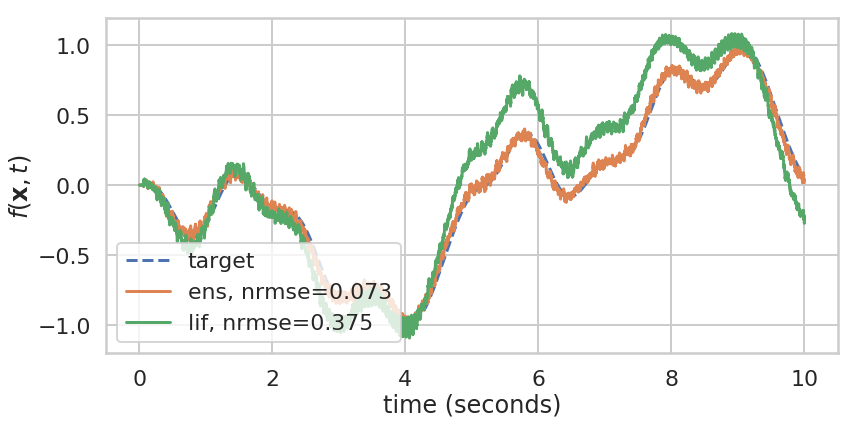

unsupervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

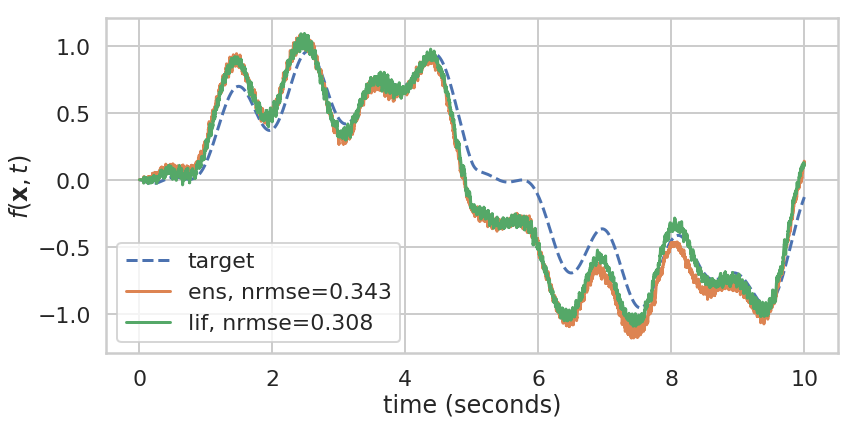

supervised simulation


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100, tau=[0.14411]: 


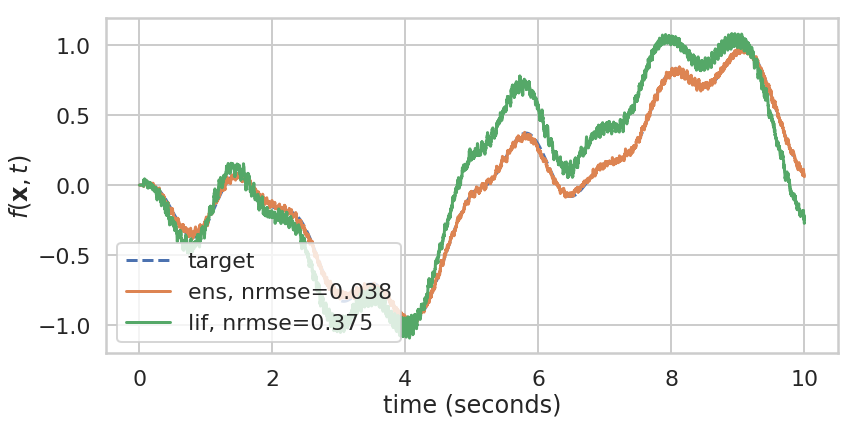

unsupervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

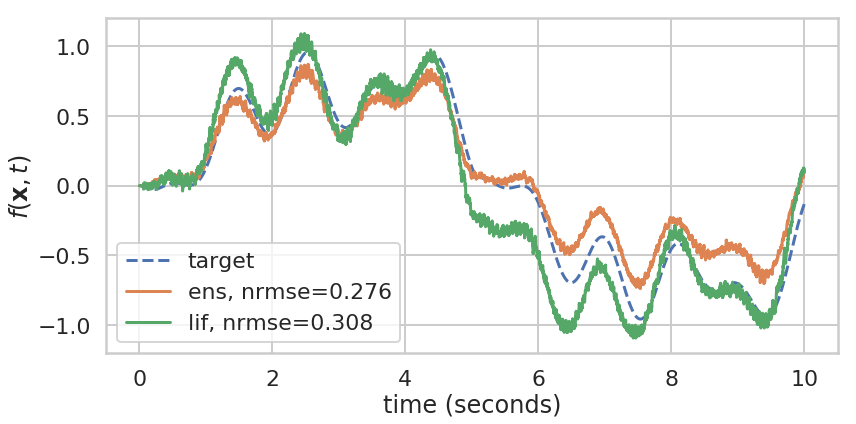

In [15]:
n_neurons = 100
max_rates = Uniform(20, 20)
intercepts = Uniform(-1, 1)
neuron_type = nengo.LIF()
t = 10

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    optimize_h=False)

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    optimize_h=True)

supervised simulation


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


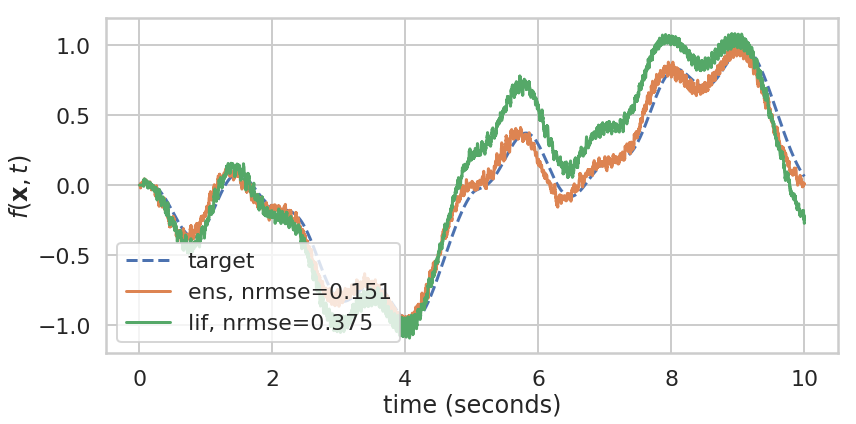

unsupervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

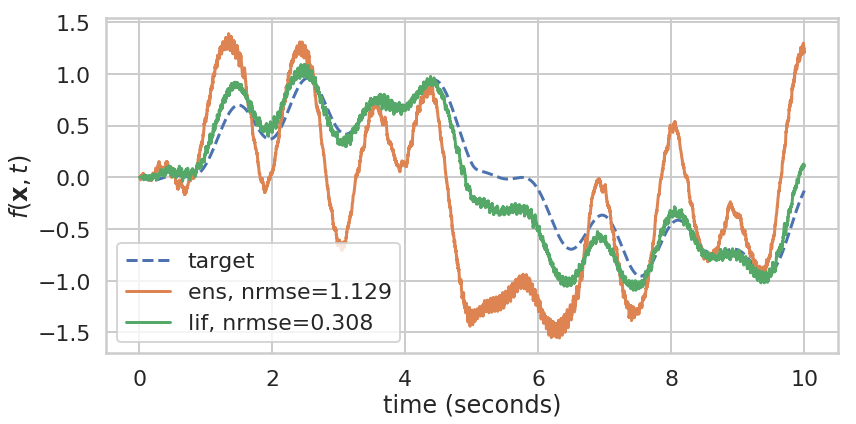

supervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100, tau=[0.20684]: 


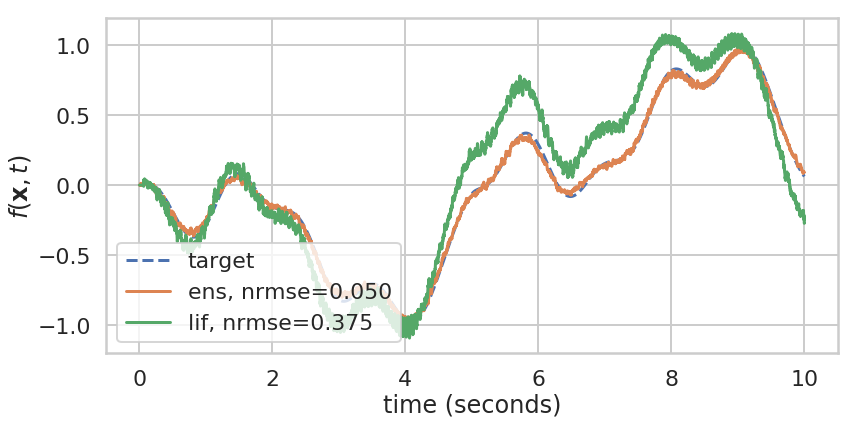

unsupervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

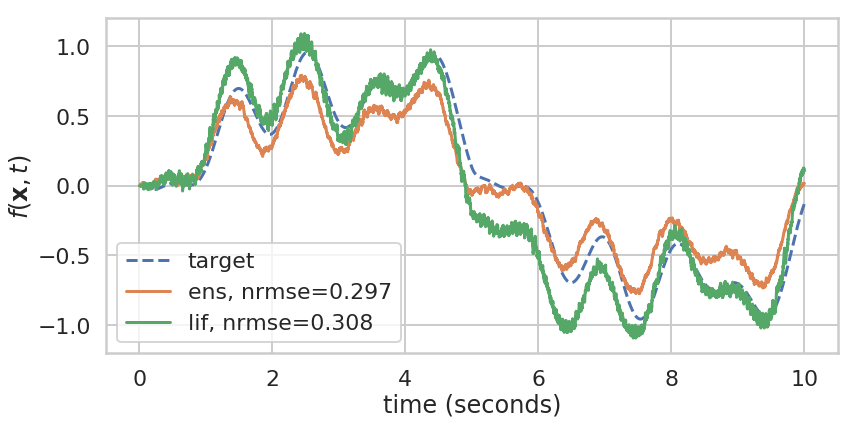

In [16]:
n_neurons = 100
max_rates = Uniform(20, 20)
intercepts = Uniform(-1, 1)
neuron_type = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)
t = 10

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    optimize_h=False)

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    optimize_h=True)

supervised simulation


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


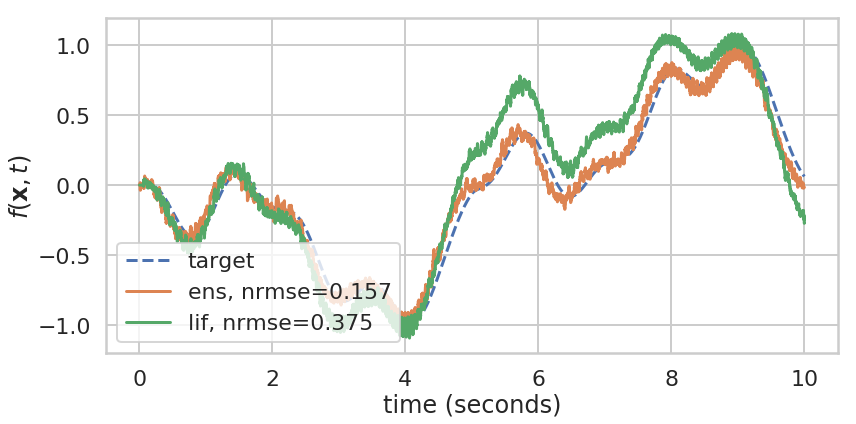

unsupervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

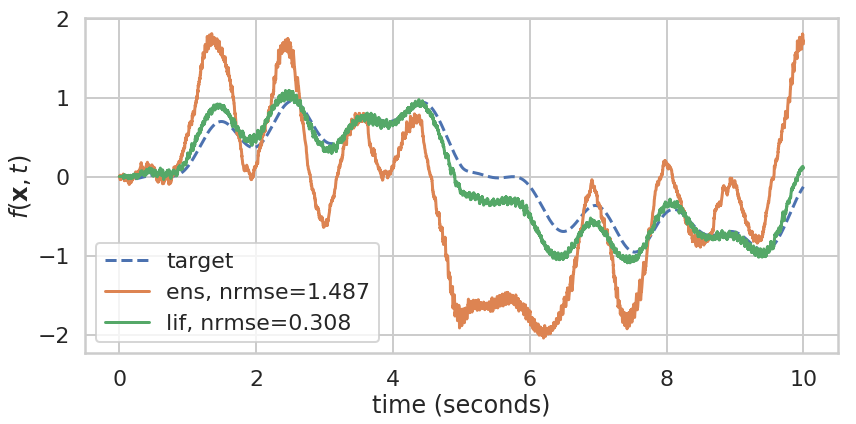

supervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100, tau=[0.21291]: 


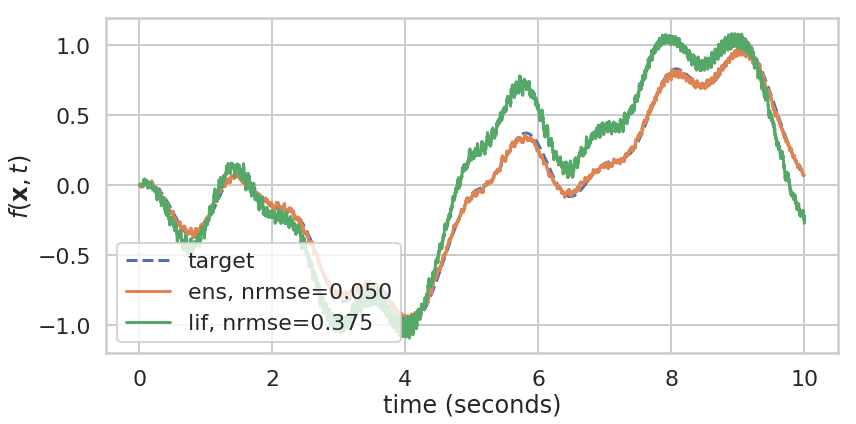

unsupervised simulation


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

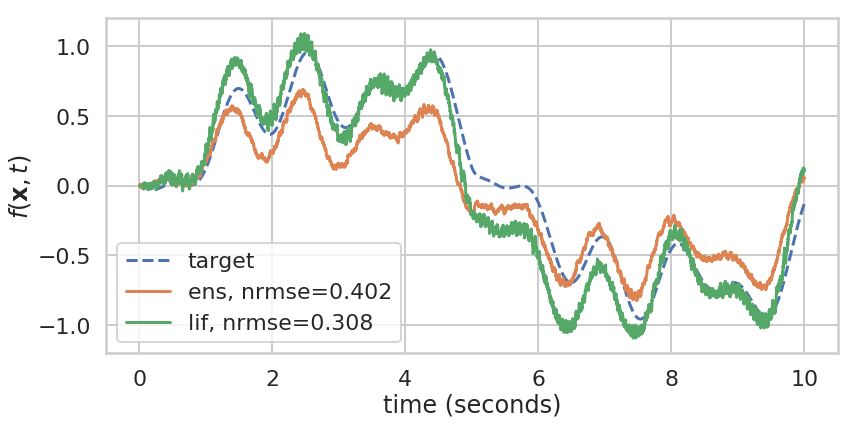

In [8]:
n_neurons = 100
max_rates = Uniform(20, 20)
intercepts = Uniform(-1, 1)
neuron_type = WilsonRK4()
t = 10

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    dt=0.00025, optimize_h=False)

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts,
    dt=0.00025, optimize_h=True)

### Durstewitz

finding gain/bias assuming on/off spiking inputs...


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

optimized gain/bias for neuron 0


optimized gain/bias for neuron 1
optimized gain/bias for neuron 2
did not find gain/bias for neuron 3 that satisfies max_rates/intercepts
did not find gain/bias for neuron 4 that satisfies max_rates/intercepts
optimized gain/bias for neuron 5
optimized gain/bias for neuron 6
optimized gain/bias for neuron 7
optimized gain/bias for neuron 8
optimized gain/bias for neuron 9
did not find gain/bias for neuron 10 that satisfies max_rates/intercepts
optimized gain/bias for neuron 11
did not find gain/bias for neuron 12 that satisfies max_rates/intercepts
did not find gain/bias for neuron 13 that satisfies max_rates/intercepts
optimized gain/bias for neuron 14
did not find gain/bias for neuron 15 that satisfies max_rates/intercepts
did not find gain/bias for neuron 16 that satisfies max_rates/intercepts
optimized gain/bias for neuron 17
did not find gain/bias for neuron 18 that satisfies max_rates/intercepts
optimized gain/bias for neuron 19
optimized gain/bias for neuron 20
optimized gain/bi

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[-0.40455 -0.54596 -0.74968  0.92842  0.56177 -0.66735  0.10537 -0.17246
 -0.69703 -0.67585  0.92694 -0.39007  0.88288 -0.84878 -0.07839 -0.74076
 -0.99043  0.10753 -0.77221  0.44405  0.39623 -0.64733  0.88348  0.44209
 -0.40406  0.41847  0.46386 -0.31555 -0.24882 -0.28179  0.23324  0.80082
 -0.65361  0.7504  -0.94469  0.32068 -0.17112  0.58256  0.4424  -0.03978
  0.28773  0.00355  0.62304 -0.04783  0.04631 -0.49896  0.21009 -0.39419
  0.15457 -0.66064 -0.68106 -0.16594 -0.14636 -0.46378 -0.73681 -0.92158
 -0.94954 -0.4569  -0.07629  0.45249 -0.05026  0.8081  -0.92956 -0.63868
 -0.32297  0.15499  0.70547 -0.2996  -0.46402 -0.87622  0.64261 -0.24067
  0.1431   0.96711 -0.99681 -0.7091   0.55822  0.61025  0.53849  0.074
  0.95771 -0.20763  0.20389 -0.87326 -0.18029  0.445   -0.52252  0.88766
  0.37357 -0.42485  0.538   -0.83367  0.94955 -0.90143  0.86691 -0.49429
  0.51565 -0.99985 -0.49152  0.4982 ]
supervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


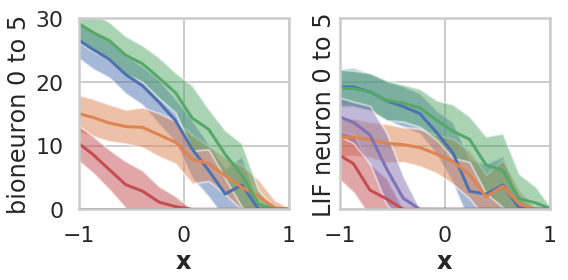

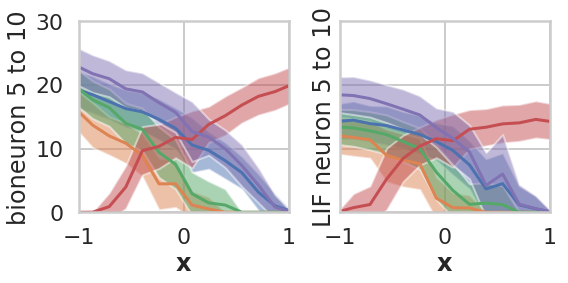

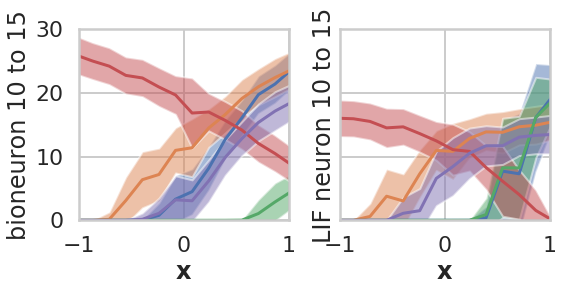

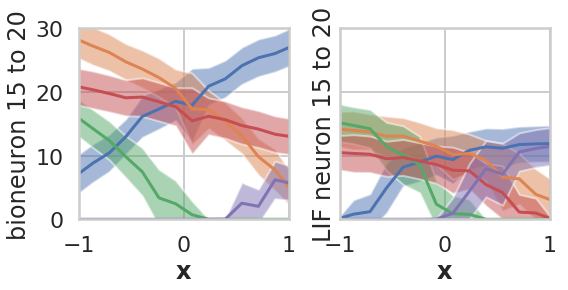

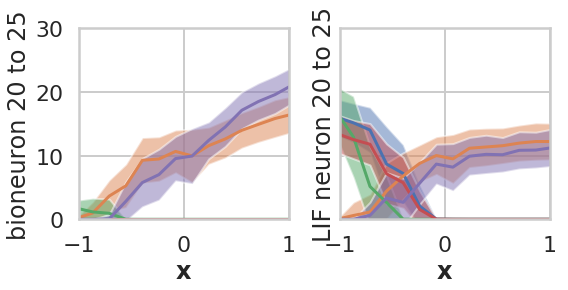

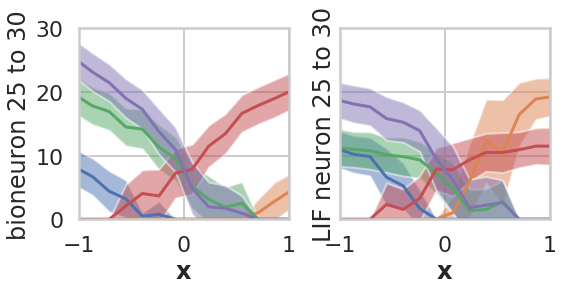

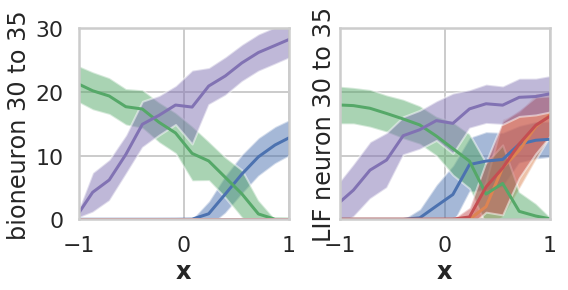

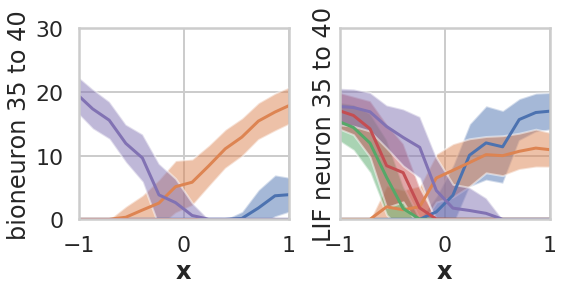

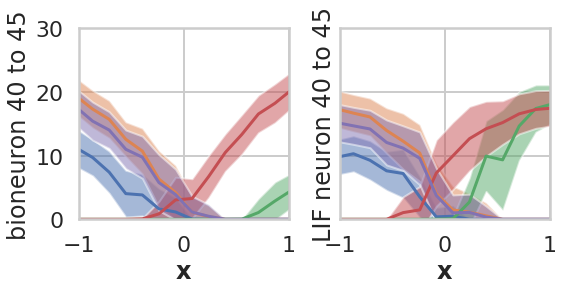

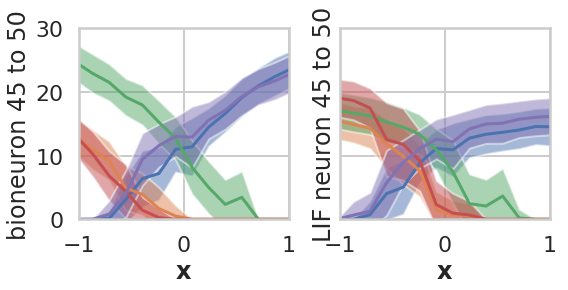

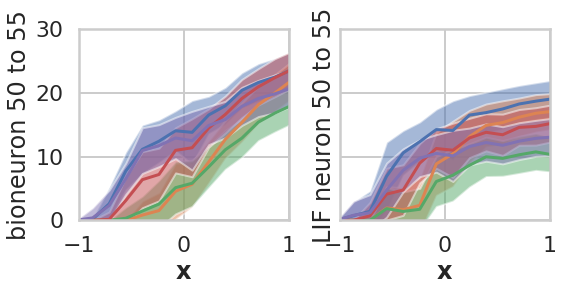

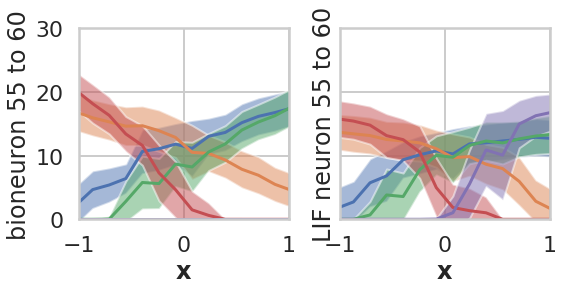

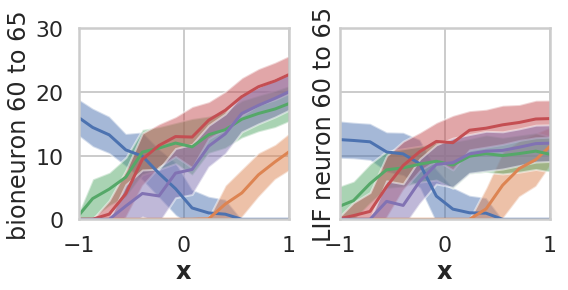

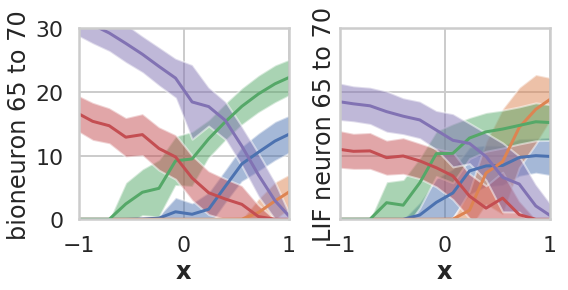

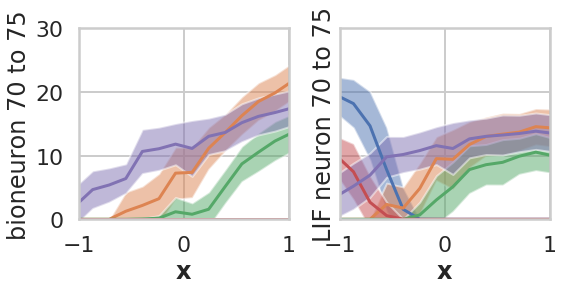

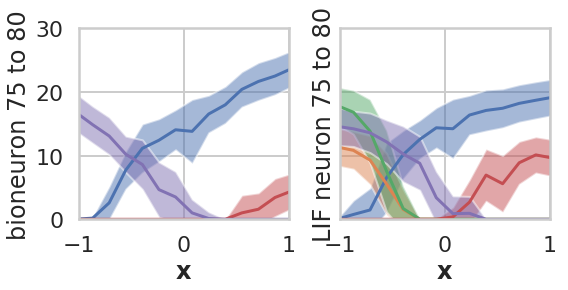

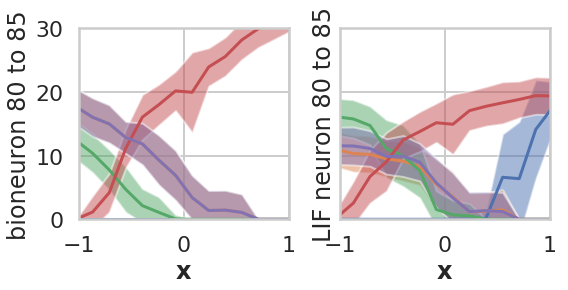

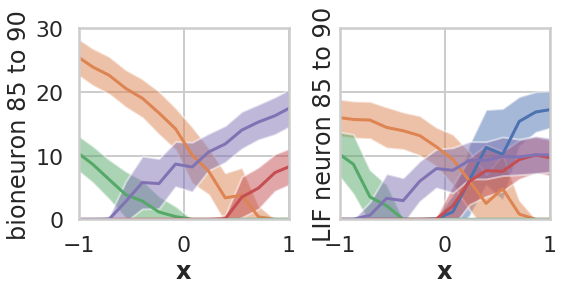

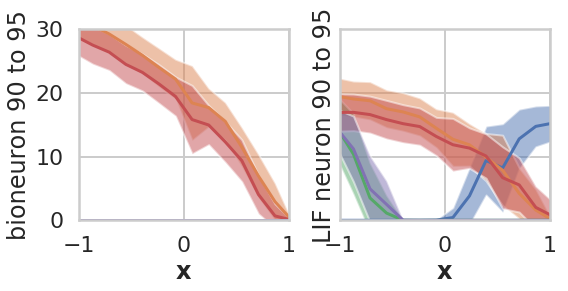

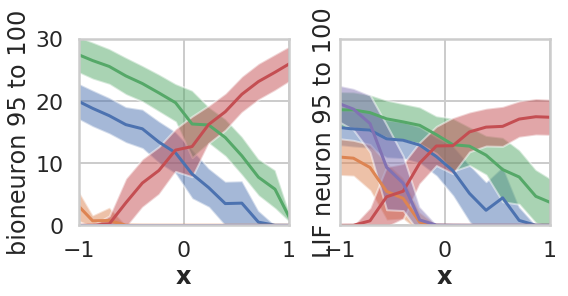

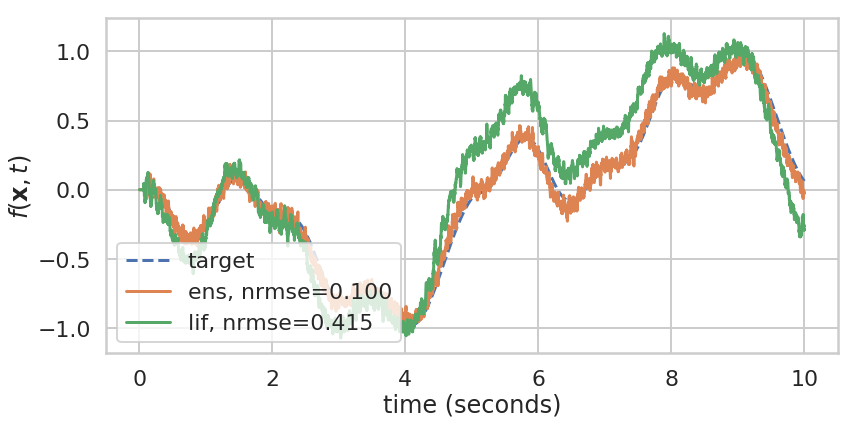

unsupervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

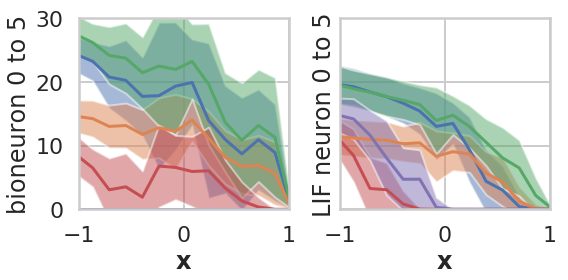

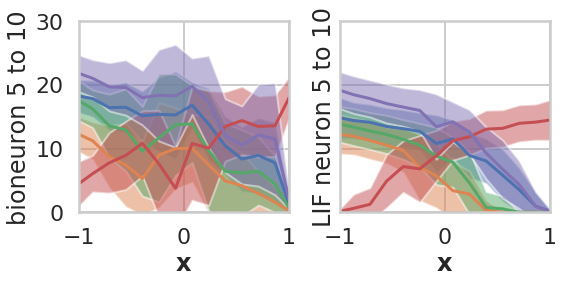

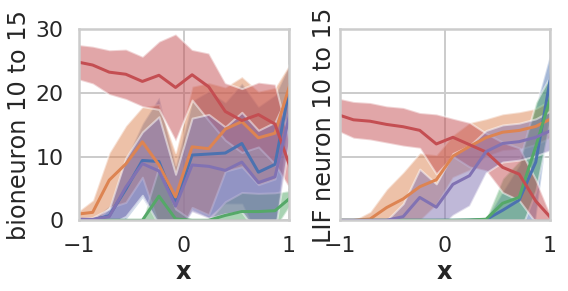

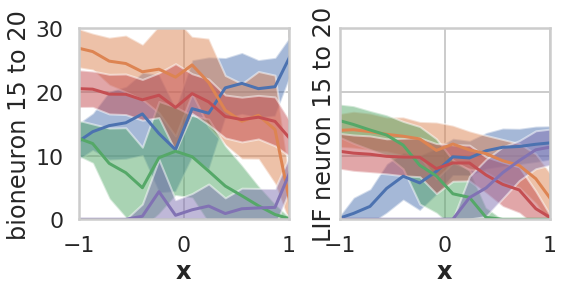

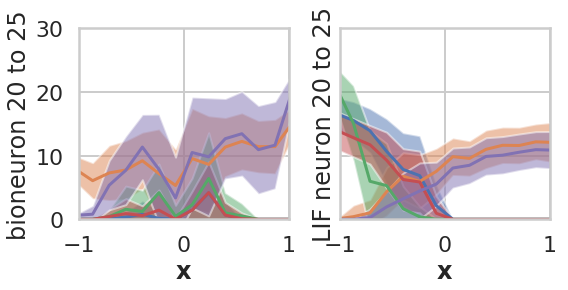

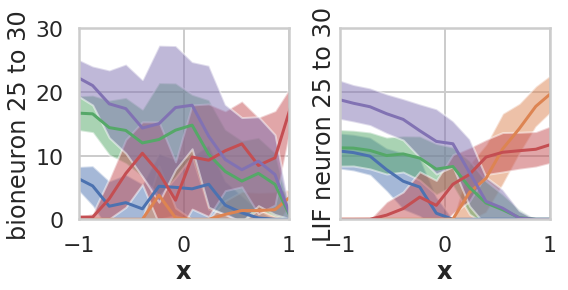

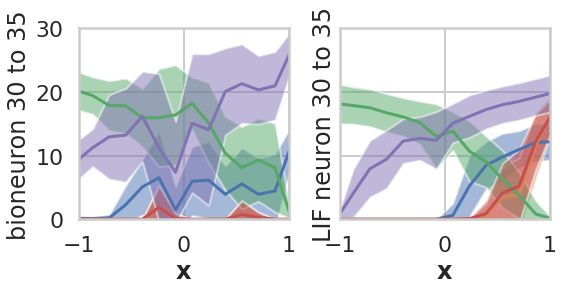

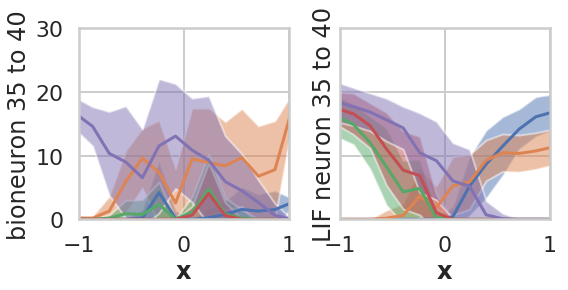

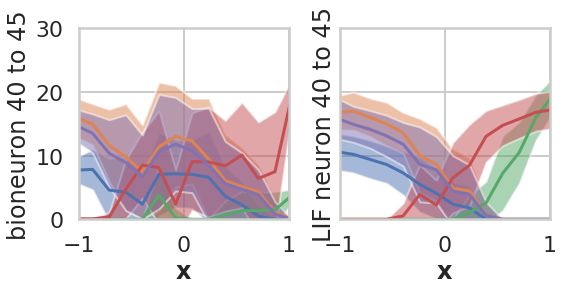

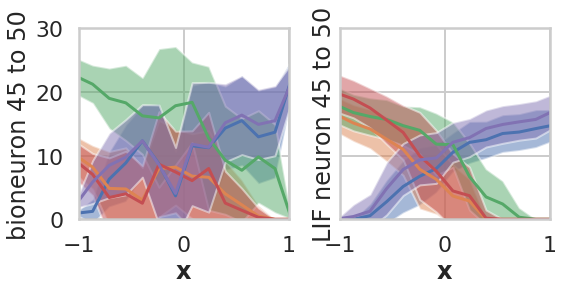

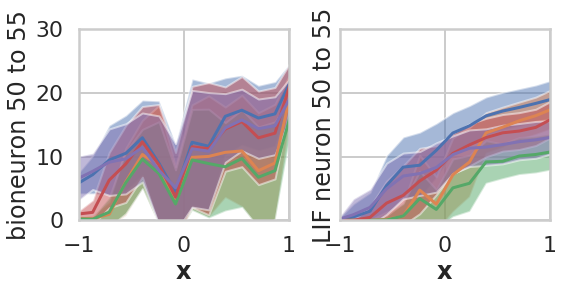

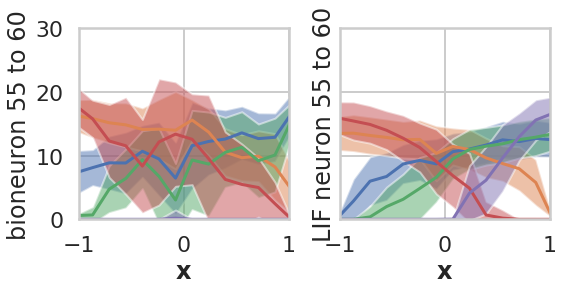

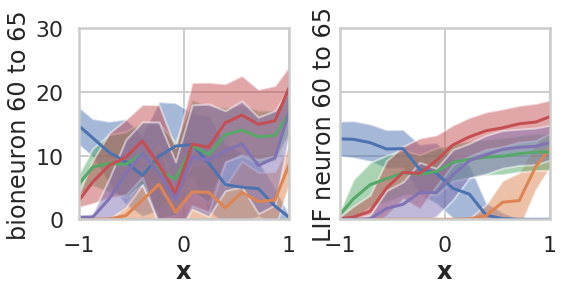

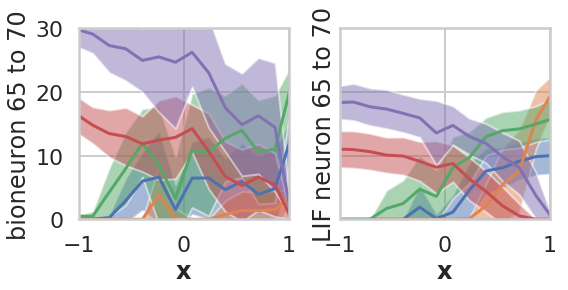

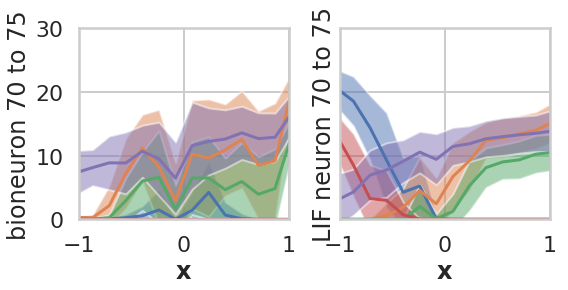

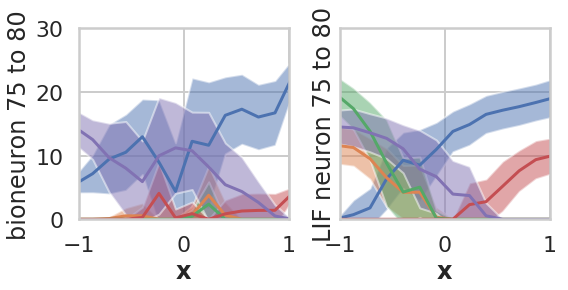

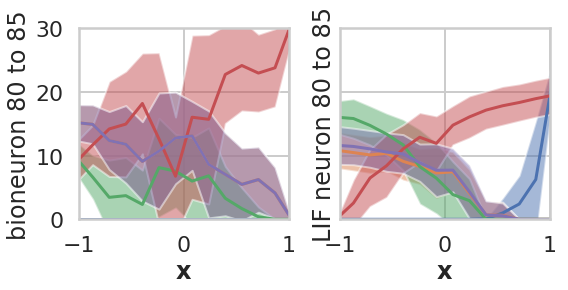

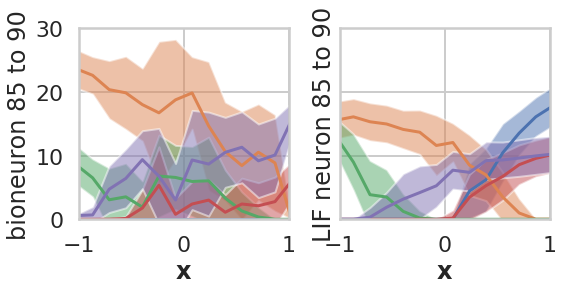

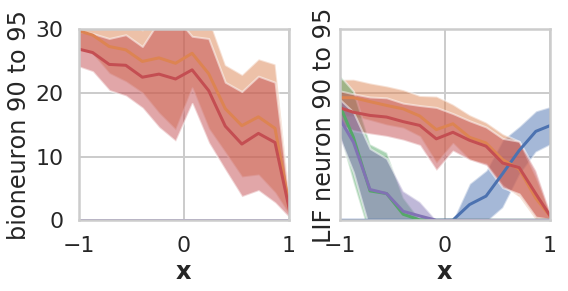

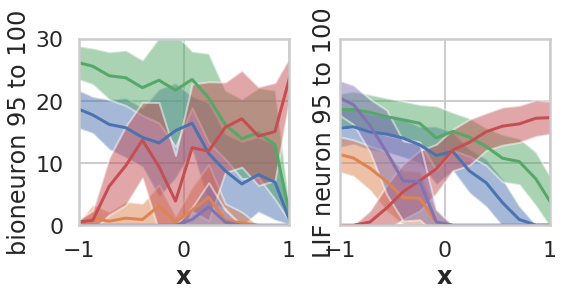

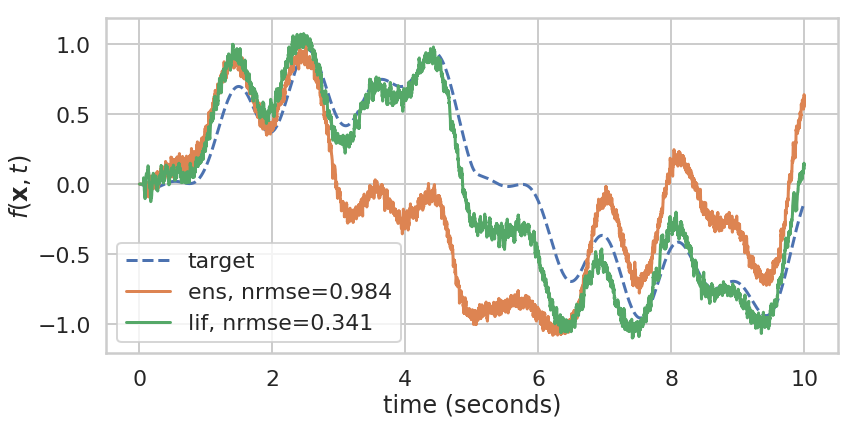

supervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and/or decoders


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 82, tau=[0.16036]: 


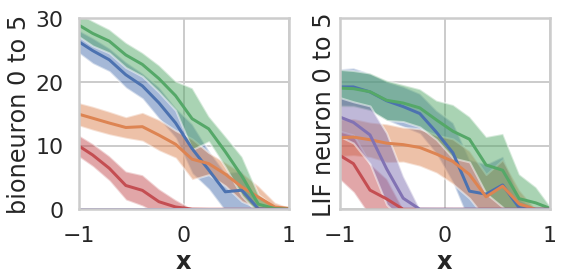

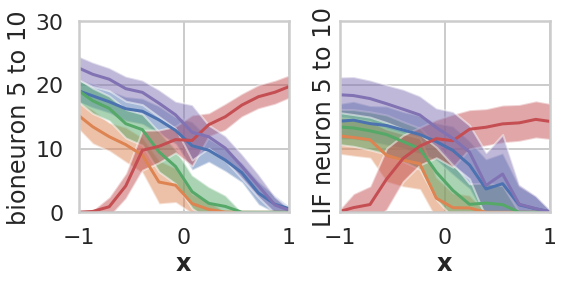

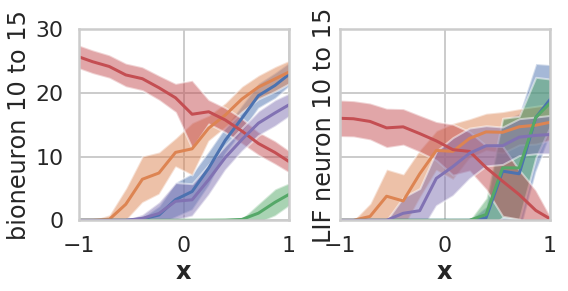

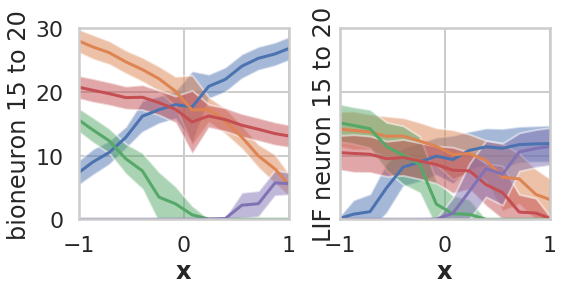

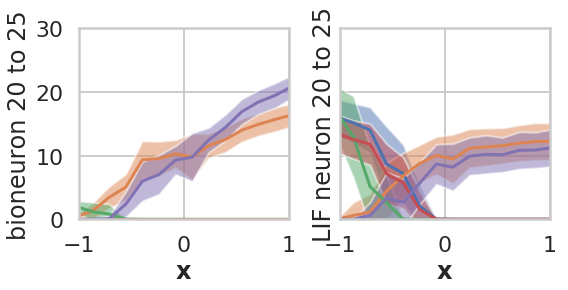

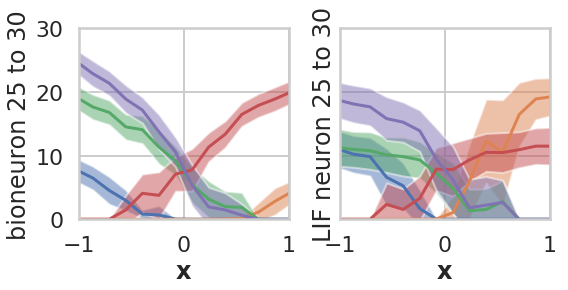

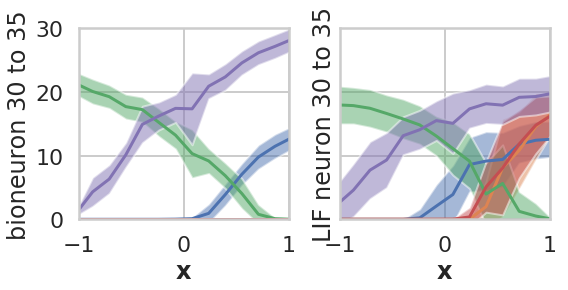

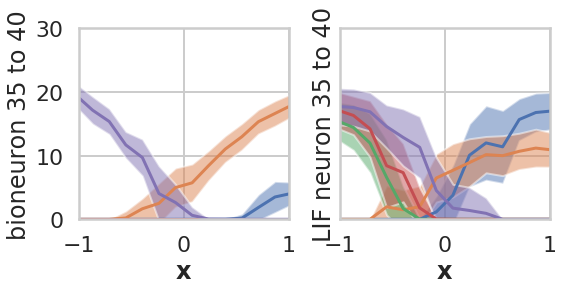

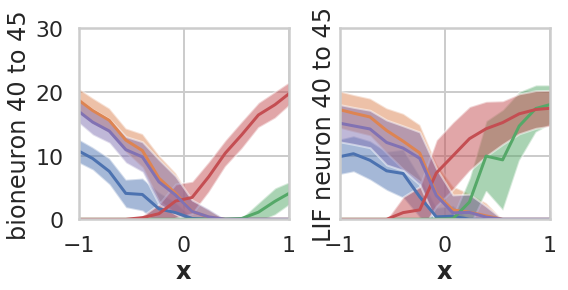

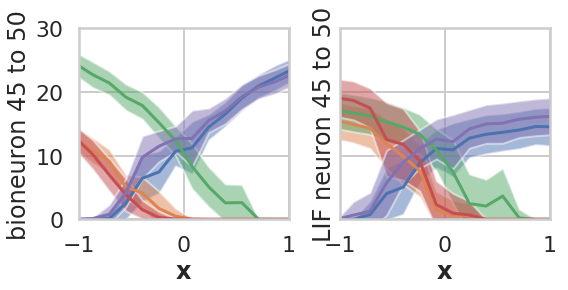

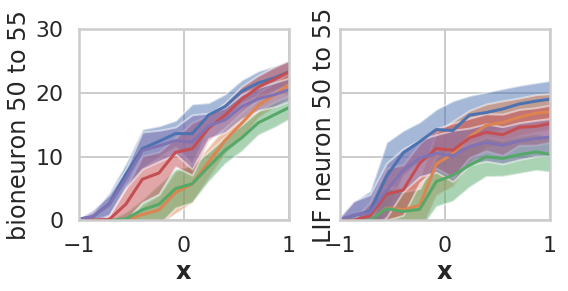

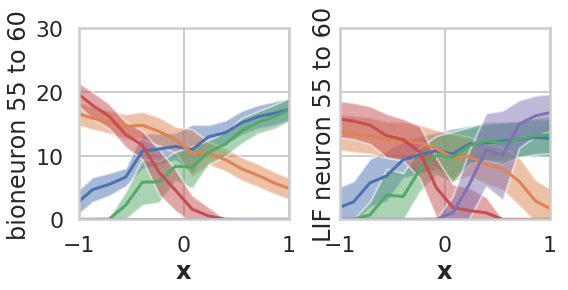

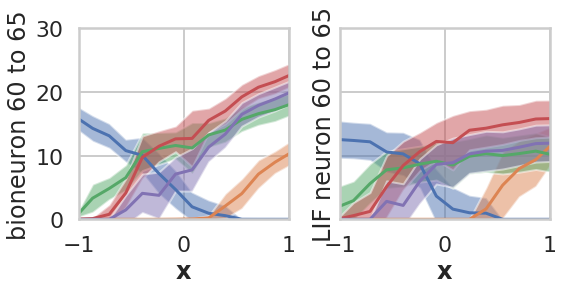

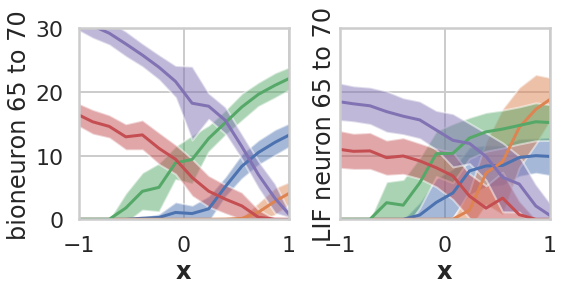

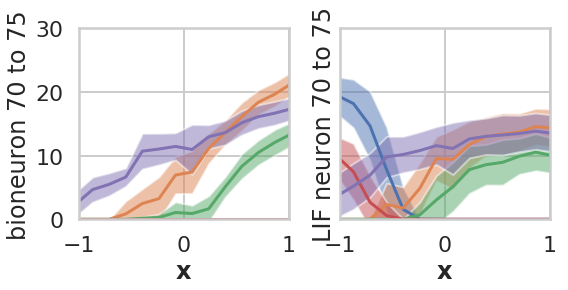

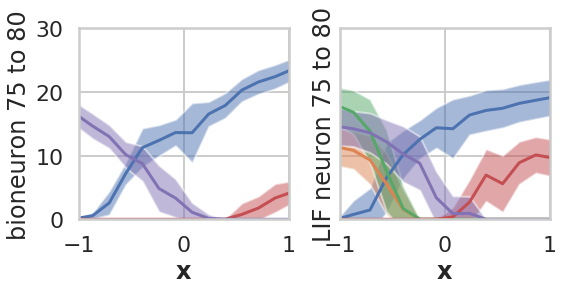

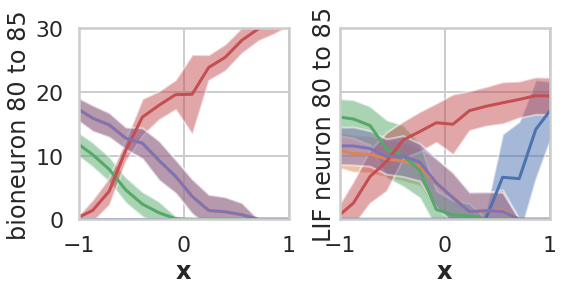

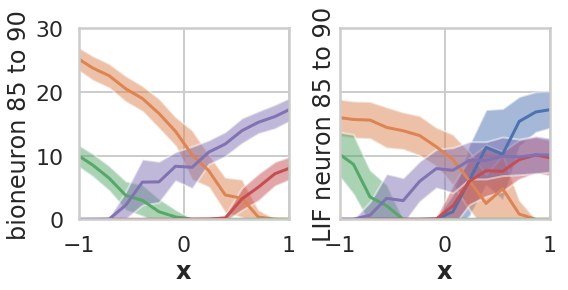

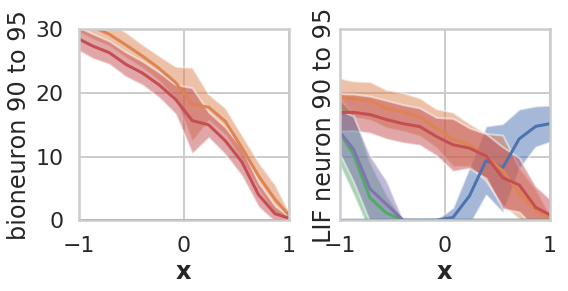

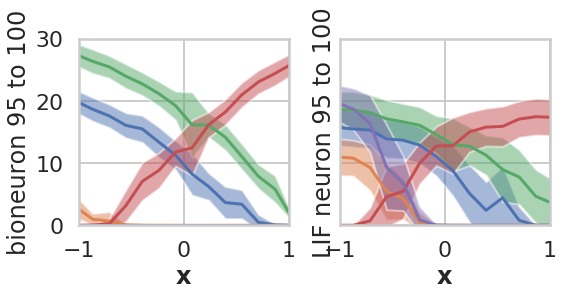

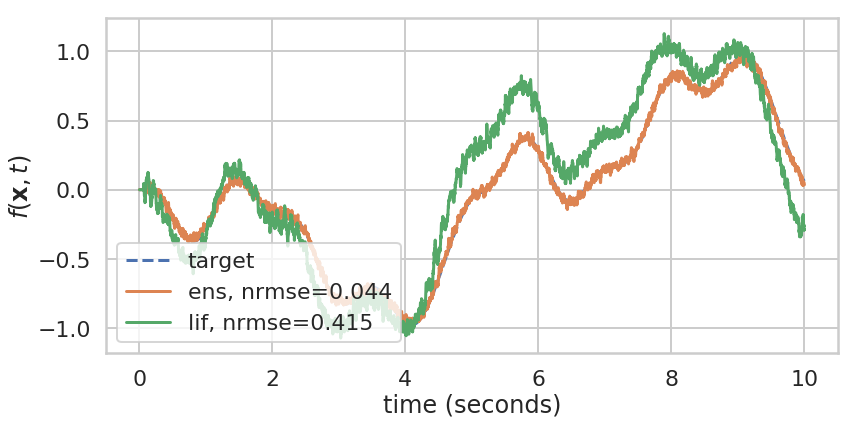

unsupervised simulation


/home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble "ens"> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

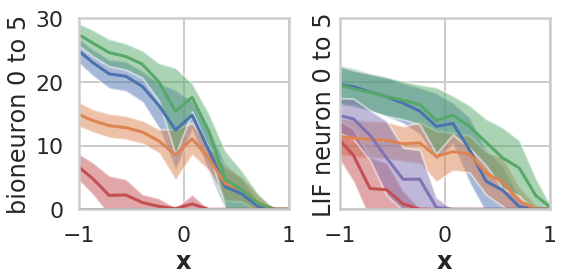

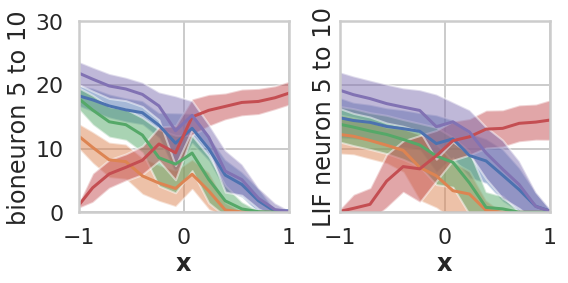

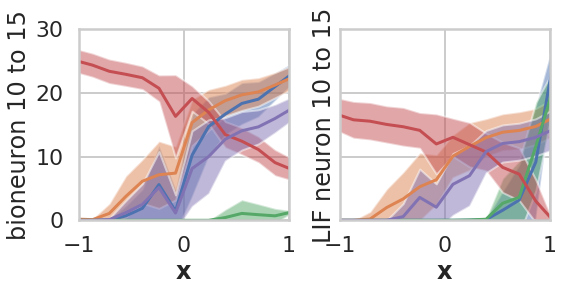

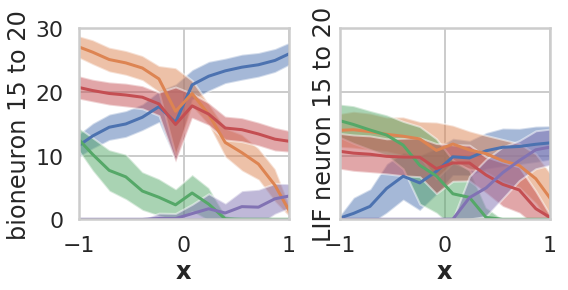

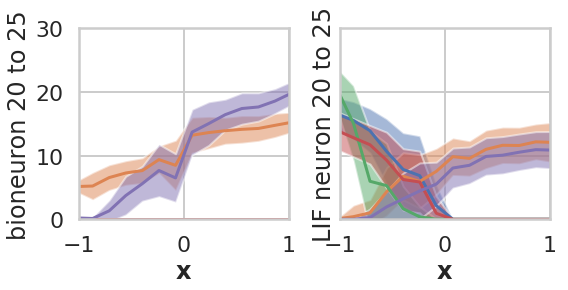

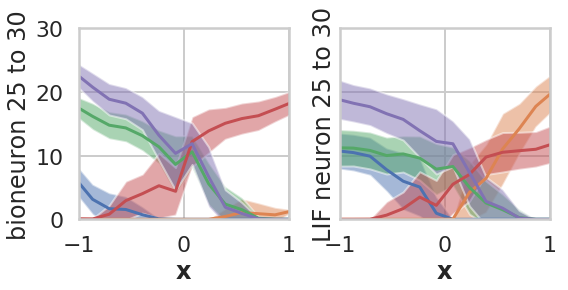

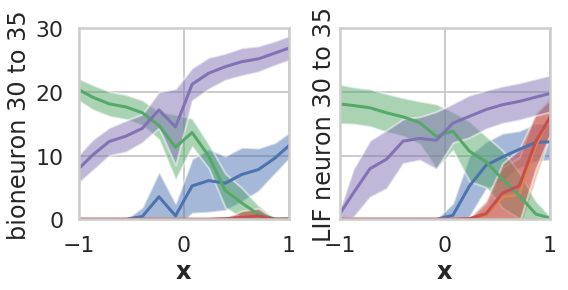

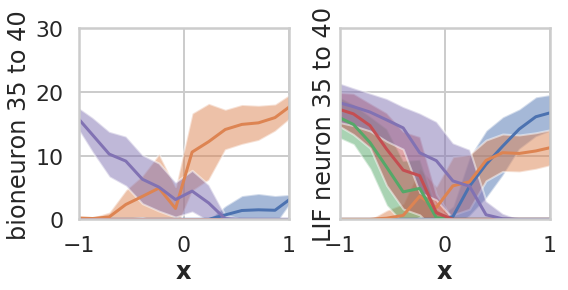

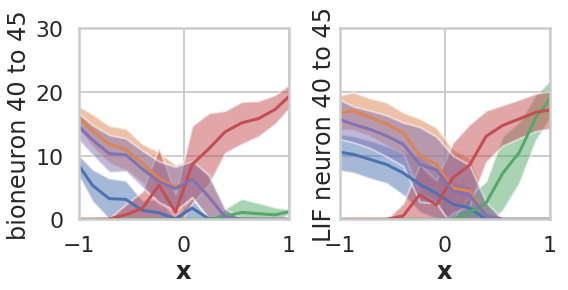

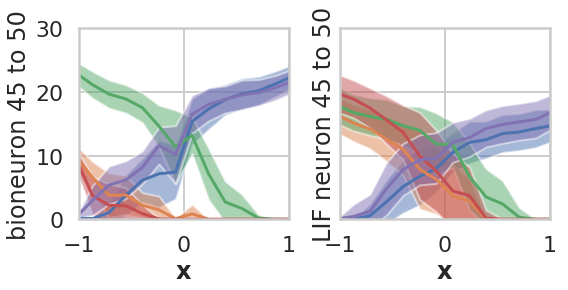

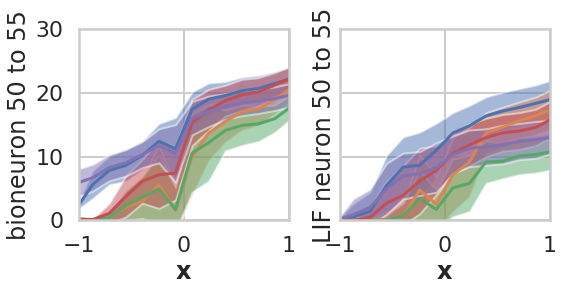

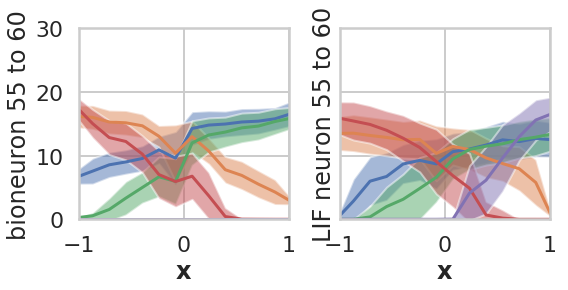

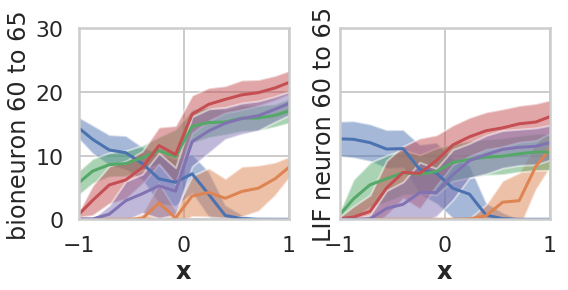

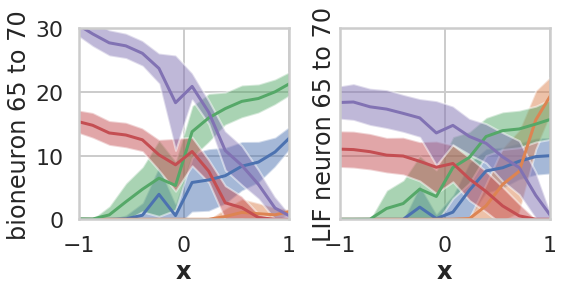

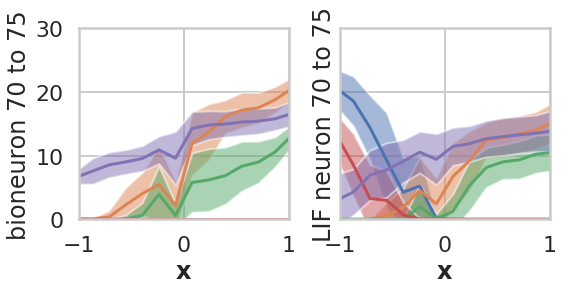

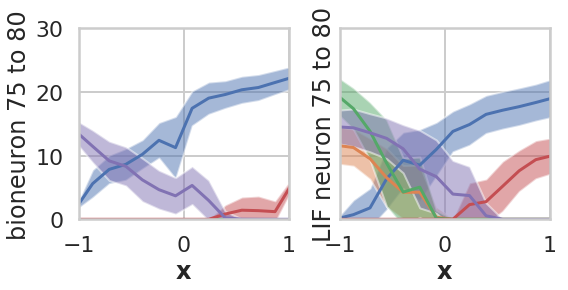

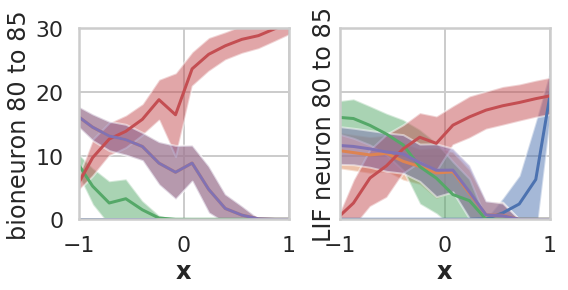

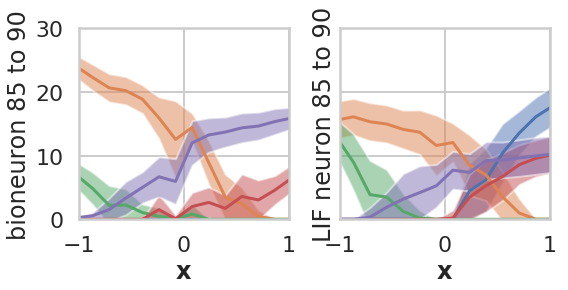

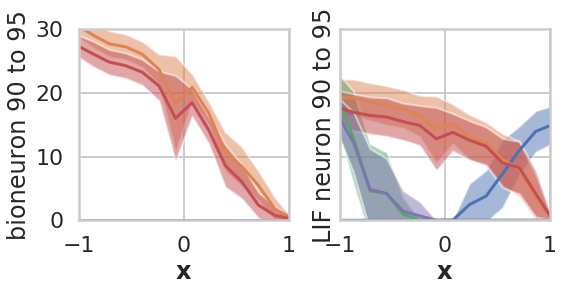

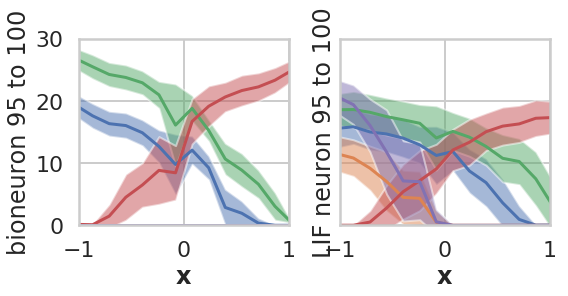

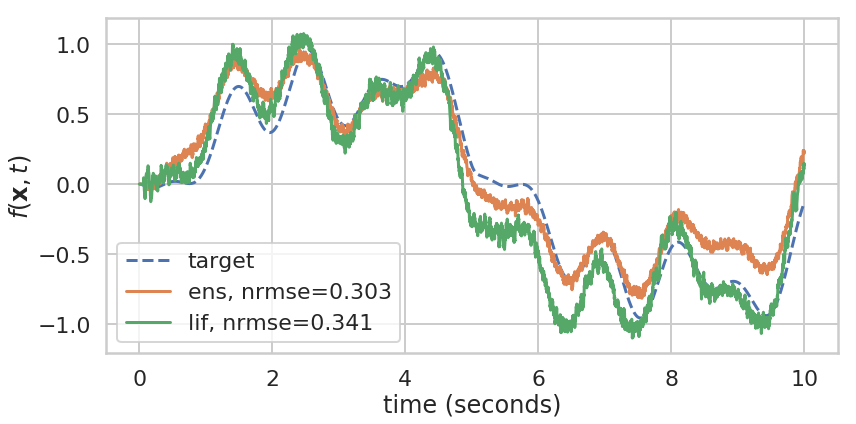

In [8]:
n_neurons = 100
max_rates = Uniform(10, 20)
intercepts = Uniform(-1, 1)
neuron_type = DurstewitzNeuron()
t = 10
k_weight = 3e0

data_gain_bias = go(n_neurons, neuron_type, 0.1, np.zeros((n_neurons, 1)), Lowpass(0.1),
    max_rates, intercepts, supv=1, seed=0, freq=500)

gain = data_gain_bias['gain']
bias = data_gain_bias['bias']

print(data_gain_bias['intercepts'])

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts, gain, bias, 
    k_weight=k_weight, dt=0.001, pt=True, optimize_h=False)

d_new, h_new, data_train, data_test = run_once(t, n_neurons, neuron_type, max_rates, intercepts, gain, bias, 
    k_weight=k_weight, dt=0.001, pt=True, optimize_h=True)